# 图像处理+180776+胡欣毅(Python版)
# 上课随堂任务

1. 生成函数及边缘增强[同第5周任务]
2. 阶跃函数柔化和边缘增强[同第5周任务]
3. 卷积信号估计:从 g(x)=f(x)*h(x) 中估计出 f(x)
4. 图像矫正(仿射变换、透视变换)
5. 图像边缘增强
6. 课后补充
* 课后补充:自编图像矫正函数,提升速度

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
%matplotlib inline

# 1. 生成函数及边缘增强

In [2]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x) )

In [3]:
x = np.linspace(-10,10,200)
y = sigmoid(x)
dy = np.diff(y)
ddy = np.diff(dy)

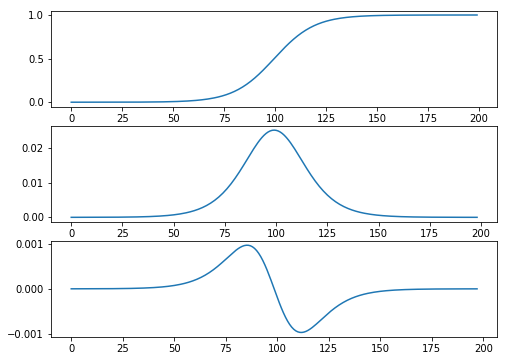

In [4]:
plt.figure(figsize=(8,6))
plt.subplot(311)
plt.plot(y)
plt.subplot(312)
plt.plot(dy)
plt.subplot(313)
plt.plot(ddy)
plt.show()

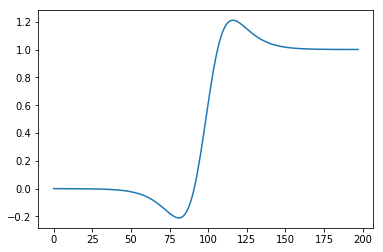

In [5]:
lamb = 400
out = y[1:-1] - lamb * ddy
plt.figure()
plt.plot(out)
plt.show()

# 2. 阶跃函数柔化和边缘增强 

In [6]:
def step_function(x):
    return np.array(x > 0, dtype=np.int)

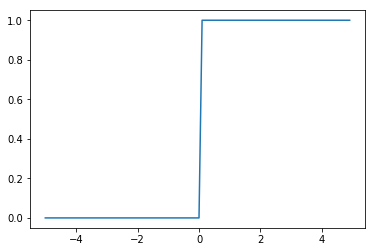

In [7]:
X = np.arange(-5.0, 5.0, 0.1)
Y = step_function(X)
plt.plot(X, Y)
plt.show()

In [8]:
sigma = .2

In [9]:
def gaosi(sigma,x):
    return np.exp(-x**2/(2*sigma**2) )/(np.sqrt(2*np.pi)*sigma)

/home/huxinyi/miniconda3/envs/hxy/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


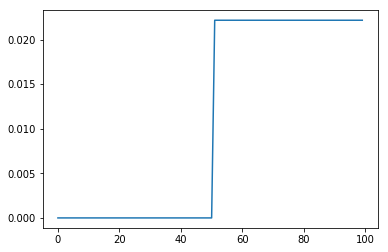

In [10]:
import scipy.signal
gaosi_filter = gaosi(sigma, np.linspace(-3*sigma,3*sigma, 8*sigma ) )

out = scipy.signal.convolve(Y,gaosi_filter)
plt.figure()
plt.plot(out)
plt.show()

In [11]:
dout = np.diff(out)
ddout = np.diff(dout)

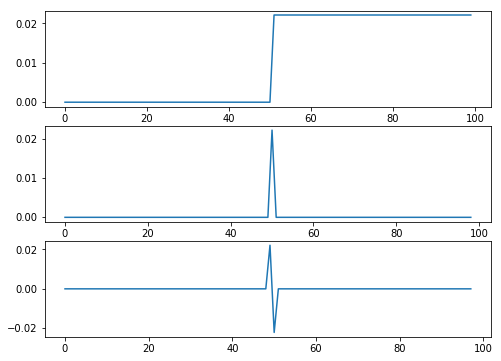

In [12]:
plt.figure(figsize=(8,6))
plt.subplot(311)
plt.plot(out)
plt.subplot(312)
plt.plot(dout)
plt.subplot(313)
plt.plot(ddout)
plt.show()

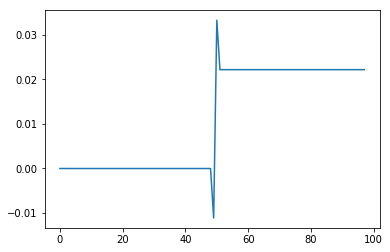

In [13]:
lambd = .5
result = out[1:-1] - lambd * ddout
plt.figure()
plt.plot(result)
plt.show()

# 3.  卷积信号估计

$$ g(x)=f(x)*h(x) $$

\begin{equation} min_{\widehat{f}}\left \|\widehat{f(x)}-f(x) \right \| \end{equation}

此设计中对应的关系
$$ g = out \quad
f = Y  \quad
h = gaosi\_filter $$

In [14]:
from scipy.fftpack import fft,ifft
N = 128
g_fft = fft(out,N)
h_fft = fft(gaosi_filter,N)
h_fft_conj = h_fft.conjugate()
print(g_fft.shape,h_fft.shape)

(128,) (128,)


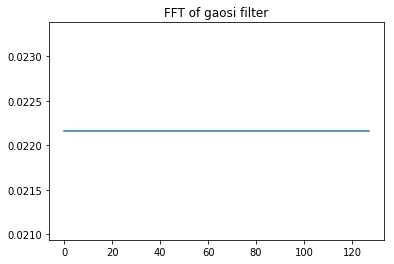

In [15]:
plt.figure()
plt.plot(abs(h_fft))
plt.title('FFT of gaosi filter')
plt.show()

$$\widehat{f} = \frac{\widehat{g}\times \widehat{h}^*}{ \widehat{h} \times \widehat{h}^* + \lambda }$$

In [16]:
lab = 0.00001
f_fft_guji = (g_fft*h_fft_conj)/(h_fft*h_fft_conj + lab )
f_guji = abs(ifft(f_fft_guji))

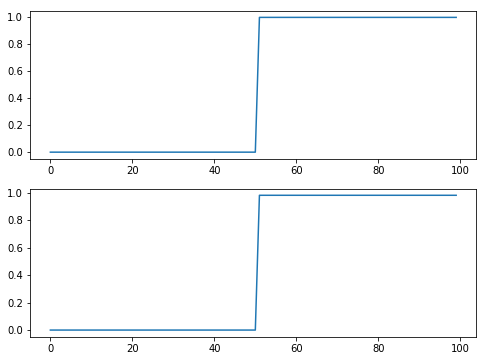

In [17]:
plt.figure(figsize=(8,6))
plt.subplot(211)
plt.plot(Y)
plt.subplot(212)
plt.plot(f_guji[:100])
plt.show()

# 4.  图像矫正

## 4.1.  透视变换

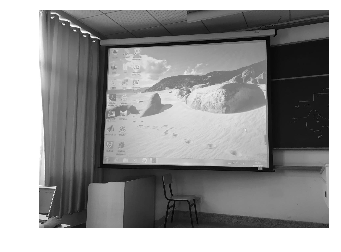

(1080, 1440)

In [18]:
im = cv2.imread('../desktop.jpeg')
im = cv2.cvtColor(im , cv2.COLOR_RGB2BGR)
gray = cv2.cvtColor(im , cv2.COLOR_RGB2GRAY)
plt.imshow(gray,cmap='gray')
plt.axis("off")
plt.show()
gray.shape

调用库函数的时间： 0.001871347427368164 s


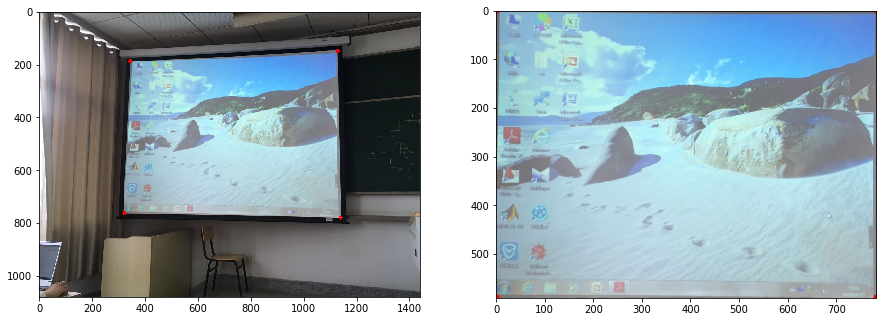

(591, 783, 3)

In [19]:
# 原图中的左上、右上、左下、右下四个点
point1 = np.float32([[345, 189], [1128, 151],\
                     [322, 763], [1140, 780]])

# 长宽比
x_len=1128 - 345
y_len=780 - 189
# 变换后分别在左上、右上、左下、右下四个点
point2 = np.float32([[0, 0], [x_len-1, 0], \
                     [0, y_len-1], [x_len-1, y_len-1]])

# 生成透视变换矩阵
M = cv2.getPerspectiveTransform(point1, point2)

time_start = time.time()

# 进行透视变换
dst = cv2.warpPerspective(im, M, (x_len,y_len))
time_end = time.time()
print('调用库函数的时间：',time_end-time_start,'s')

for point in point1:
    cv2.circle(im, tuple(point), 5, (255, 0, 0), 4)
    
for point in point2:
    cv2.circle(dst, tuple(point), 5, (255, 0, 0), 4)

plt.figure(figsize=(15,12))
plt.subplot(121)
plt.imshow(im,cmap='gray')
plt.subplot(122)
plt.imshow(dst,cmap='gray')
plt.show()
dst.shape

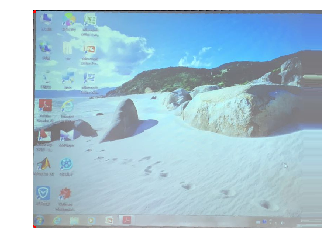

In [20]:
# 自己的透视变换
M_inv = np.linalg.inv(M)
myim = np.zeros((y_len, x_len,3))
for y in range(y_len):
    for x in range(x_len):
        xy1 = M_inv.dot(np.array([[x],[y],[1]]))
        xx ,yy = xy1[0] / xy1[2] , xy1[1]/xy1[2]
        myim[y,x,:] = im[np.clip(yy,0,1440).astype(int),\
                         np.clip(xx,0,1080).astype(int) , :]
plt.imshow(myim.astype(int),cmap='gray')
plt.axis("off")
plt.show()

## 4.2.  仿射变换

调用库函数的时间： 0.0012640953063964844 s


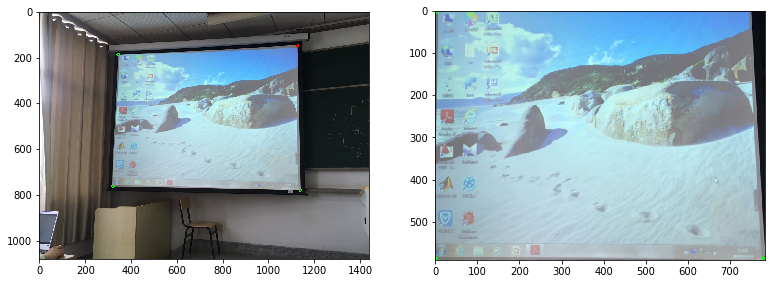

(591, 783, 3)

In [21]:
# 原图中的左上、右上、左下、右下四个点
point1 = np.float32([[345, 189], [322, 763],\
                     [1140, 780]])

# 长宽比
x_len=1128 - 345
y_len=780 - 189
# 变换后分别在左上、右上、左下、右下四个点
point2 = np.float32([[0, 0], [0, y_len-1], \
                     [x_len-1, y_len-1]])

M = cv2.getAffineTransform(point1,point2)

time_start = time.time()

dst = cv2.warpAffine(im,M,(x_len,y_len))

time_end = time.time()
print('调用库函数的时间：',time_end-time_start,'s')

for point in point1:
    cv2.circle(im, tuple(point), 5, (0, 255, 0), 4)
    
for point in point2:
    cv2.circle(dst, tuple(point), 5, (0, 255, 0), 4)

plt.figure(figsize=(13,10))
plt.subplot(121)
plt.imshow(im,cmap='gray')
plt.subplot(122)
plt.imshow(dst,cmap='gray')
plt.show()
dst.shape

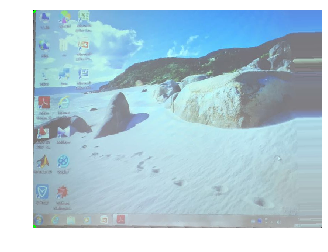

In [22]:
# 自己的仿射变换
M1 = np.vstack( (M, np.array([0,0,1])) )
M_inv = np.linalg.inv(M1)
myim = np.zeros((y_len, x_len,3))
for y in range(y_len):
    for x in range(x_len):
        xy1 = M_inv.dot(np.array([[x],[y],[1]]))
        #print(xy1.reshape(1,-1))
        myim[y,x,:] = im[np.clip(xy1[1],0,1440).astype(int),\
                         np.clip(xy1[0],0,1080).astype(int) , :]
plt.imshow(myim.astype(int),cmap='gray')
plt.axis("off")
plt.show()

# 5.  图像边缘增强

获取模糊图像$$f_{out}$$

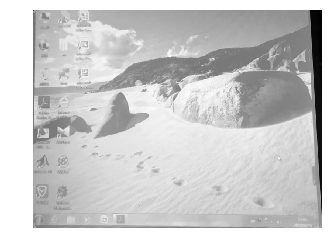

In [23]:
f_out = cv2.cvtColor(dst , cv2.COLOR_RGB2GRAY)
plt.imshow(f_out,cmap='gray')
plt.axis("off")#去除坐标轴
plt.show()

In [24]:
# Laplace算子
Laplace = np.array([[1, 1, 1],
                    [1,-8, 1],
                    [1, 1, 1]])

计算$$ \Delta f$$

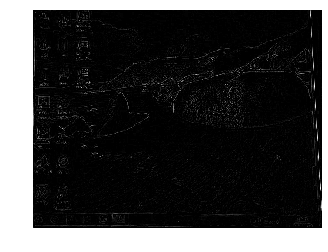

In [25]:
deta_f = cv2.filter2D(f_out,-1,Laplace)
plt.imshow(deta_f,cmap='gray')
plt.axis("off")#去除坐标轴
plt.show()

In [26]:
labd = .2
re_build = np.clip(abs(f_out - (labd * deta_f).astype(int)),0,255)

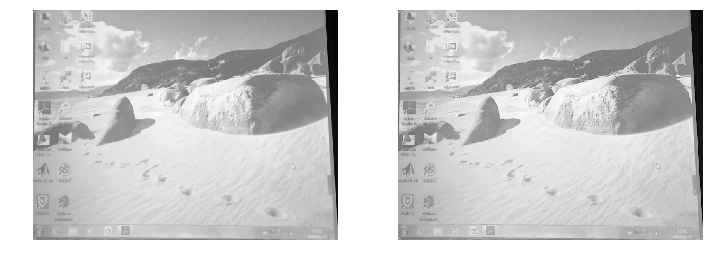

In [27]:
plt.figure(figsize=(12,10))
plt.subplot(121)
plt.imshow(f_out,cmap='gray')
plt.axis("off")
plt.subplot(122)
plt.imshow(re_build,cmap='gray')
plt.axis("off")
plt.show()

In [28]:
# 图像清晰度值
def getImageVar(image):
    imageVar = cv2.Laplacian(image, cv2.CV_64F).var()
    return imageVar

In [29]:
print(getImageVar(f_out),getImageVar(re_build.astype(float)))

94.88387495200539 263.1572273777786


# 6.   课后补充

## 6.1.1.  透视变换

$$
\operatorname{dst}(x, y)=\operatorname{src}\left(\frac{M_{11} u+M_{12} v+M_{13}}{M_{31} u+M_{32} v+M_{33}}, \frac{M_{21} u+M_{22} v+M_{23}}{M_{31} u+M_{32} v+M_{33}} \right)
$$

$$ M = \begin{bmatrix}
\alpha \\ \beta \\ \gamma 
\end{bmatrix} $$

$$ x= \frac{M_{11} u+M_{12} v+M_{13}}{M_{31} u+M_{32} v+M_{33}}=\frac{\alpha T}{\gamma T} \qquad y = \frac{M_{21} u+M_{22} v+M_{23}}{M_{31} u+M_{32} v+M_{33}} = \frac{\beta T}{\gamma T} $$

$$ \begin{bmatrix}
\alpha -x \times \gamma \\ 
\beta -y \times \gamma 
\end{bmatrix} T = 0 $$

$$ T = \begin{bmatrix}
u \\ v\\ 1 
\end{bmatrix} $$

## 6.1.2.  透视变换改进

$$\left[ \begin{matrix} x'\\ y'\\ w \end{matrix} \right] = M  \left[ \begin{matrix} u\\ v\\ 1 \end{matrix} \right]  \qquad  \frac{1}{w}\left[ \begin{matrix} x'\\ y'\\ w \end{matrix} \right] =  \left[ \begin{matrix}
x\\ y\\ 1 \end{matrix} \right] =  \frac{1}{w} M  \left[ \begin{matrix} u\\ v\\ 1 \end{matrix} \right]    \qquad   M ^{-1}\left[ \begin{matrix} x\\ y\\ 1  \end{matrix} \right] =   \left[ \begin{matrix} u'\\ v'\\ t' \end{matrix} \right]   \qquad   \left[ \begin{matrix} u\\ v \end{matrix} \right]  =   \left[ \begin{matrix}
u'/ t'\\ v'/ t' \end{matrix} \right] $$ 

## 6.2.  仿射变换

$$ 
 \left[ \begin{matrix} x\\ y\\ 1 \end{matrix} \right] = M   \left[ \begin{matrix} u\\ v\\ 1 \end{matrix} \right]  \qquad 
M ^{-1}\left[ \begin{matrix} x\\ y\\ 1 \end{matrix} \right] =  \left[ \begin{matrix} u\\ v\\ 1 \end{matrix} \right] $$

## 6.3. 插值方法

[双线性插值](https://cniter.github.io/posts/e124baa1.html#fn1)

## 6.4. 各个版本计算时间对比 

调用opencv 仿射变换库函数运行 : 0.022718s

自编仿射变换函数运行 : 0.542926s

调用opencv透视变换函数运行 : 0.007209s

自编透视变换函数(solve解方程)运行 : 0.938072s

自编透视变换函数(Mat取逆解方程)运行 : 1.11784s

自编透视变换函数优化版运行 : 0.557861s


# 图像处理+180776+胡欣毅(C++版)

[c++](c++/hxy.cpp) 、  　[霍夫变换边缘点检测c++](c++/wrap_hough.cpp)